In [1]:
import sys 
sys.path.append('/home/katrin/Documents/gammapy')


import gammapy 
#print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )
print(gammapy)

Supposed to be 1.0 (21-12-2022)
<module 'gammapy' from '/home/katrin/Documents/gammapy/gammapy/__init__.py'>


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map, MapAxis
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
#from my_dataset_maps_20 import MapDatasetNuisance
#from  my_fit_20 import Fit


from scipy.optimize import curve_fit

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'

path = '/home/katrin/Documents/'
path_crab = '/home/katrin/Documents/Crab'


dataset_read = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_read = dataset_read.downsample(4)



In [4]:
edispkernelmap_read = dataset_read.edisp 
edispkernelmapmap_read = edispkernelmap_read.edisp_map
edispkernel_read  = edispkernelmap_read.get_edisp_kernel() 
 
    
energy = edispkernelmapmap_read.geom.axes['energy'].copy()
energy_true = edispkernelmapmap_read.geom.axes['energy_true'].copy()

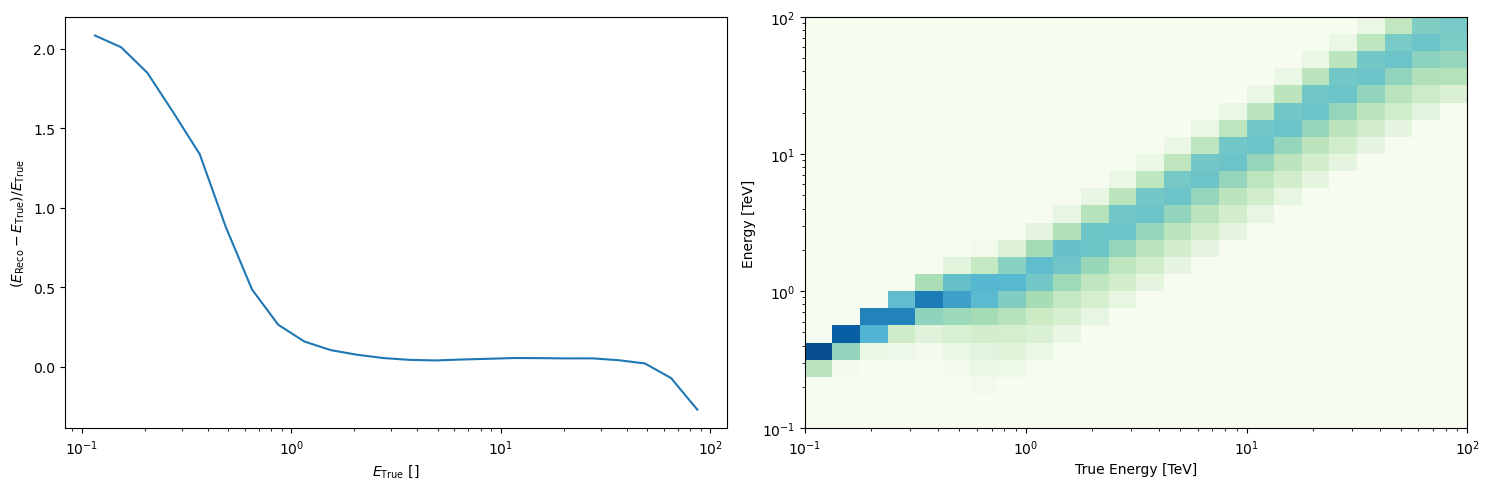

In [5]:
from gammapy.maps import MapAxis
from gammapy.irf import EDispKernel


bias_read = np.array([edispkernel_read.get_bias(_).value[0] for _ in energy_true.center])
resolution_read = np.array([edispkernel_read.get_resolution(_).value[0] for _ in energy_true.center])
edisp_simulated = EDispKernel.from_gauss(
    energy_axis_true=energy_true, energy_axis=energy, sigma=np.mean(resolution_read), bias=bias_read
)

edisp_simulated.peek()

In [6]:
from gammapy.irf.edisp.map import EDispKernelMap
edisp_simulated_map = EDispKernelMap.from_edisp_kernel(edisp_simulated)

In [7]:
dataset_simulated = dataset_read.copy()


models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)
bkg_model = FoVBackgroundModel(dataset_name=dataset_simulated.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_simulated.models = models

dataset_simulated.edisp = edisp_simulated_map
dataset_simulated.counts = dataset_simulated.npred()

print(dataset_simulated)


penality 0 []
MapDataset
----------

  Name                            : V4-95qTG 

  Total counts                    : 361815 
  Total background counts         : 360331.31
  Total excess counts             : 1484.08

  Predicted counts                : 361815.39
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1484.04

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -756744.81

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    P

Text(0.5, 1.0, 'Residual Standard Dataset')

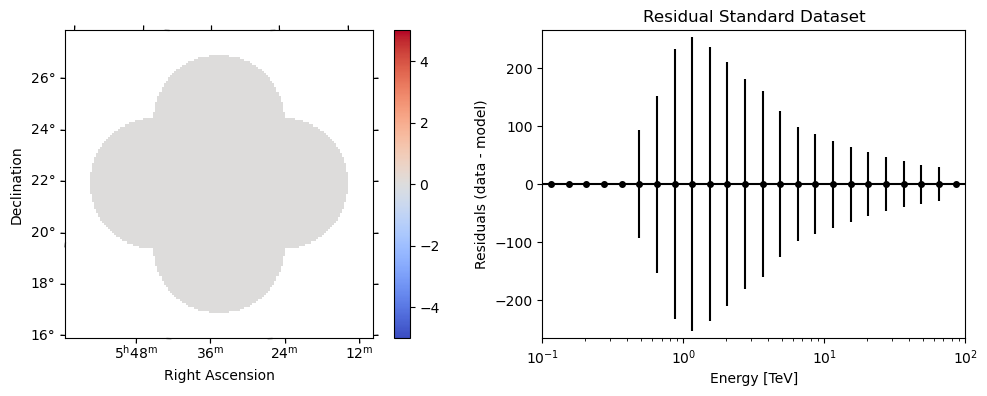

In [8]:
dataset_simulated.plot_residuals()
fig =plt.gcf()
plt.title("Residual Standard Dataset")


## Modification of edisp

In [9]:
delta_sigma = 0.0
delta_bias = 0.1


edisp_modified = EDispKernel.from_gauss(
    energy_axis_true=energy_true, energy_axis=energy, sigma=np.mean(resolution_read) + delta_sigma, 
    bias=bias_read + delta_bias
)
edisp_modified_map = EDispKernelMap.from_edisp_kernel(edisp_modified)


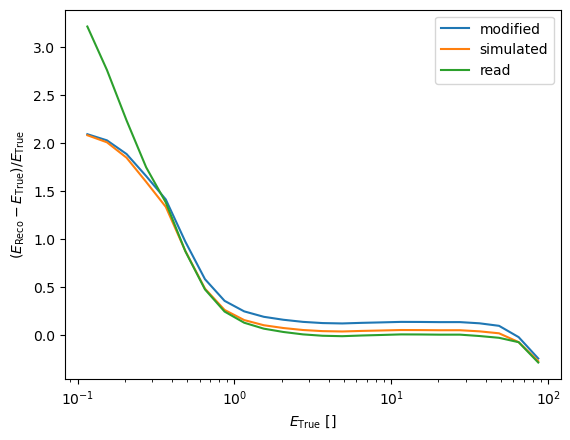

In [10]:
ax = edisp_modified.plot_bias(label="modified")
edisp_simulated.plot_bias(ax, label = 'simulated')
edispkernel_read.plot_bias(ax, label = 'read')

ax.legend()

In [11]:
dataset_modified = dataset_simulated.copy()


models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)
bkg_model = FoVBackgroundModel(dataset_name=dataset_modified.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_modified.models = models

dataset_modified.edisp = edisp_modified_map

print(dataset_modified)


penality 0 []
MapDataset
----------

  Name                            : Wma2Ilku 

  Total counts                    : 361815 
  Total background counts         : 360331.31
  Total excess counts             : 1484.08

  Predicted counts                : 361818.96
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1487.62

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -756738.33

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    P

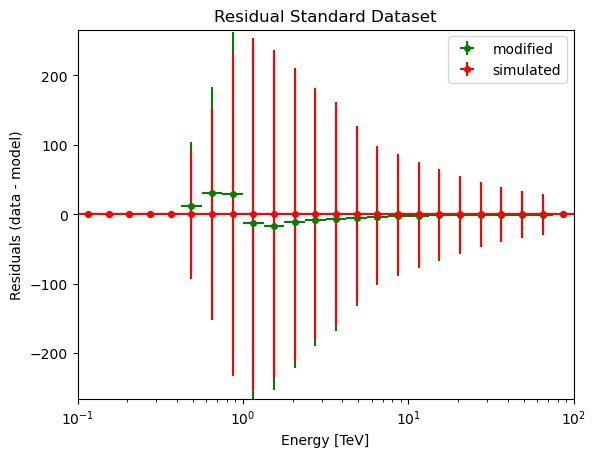

In [12]:
ax = dataset_modified.plot_residuals_spectral(color = 'green', label = "modified")
dataset_simulated.plot_residuals_spectral(ax, color = 'red', label = "simulated")

fig =plt.gcf()
plt.title("Residual Standard Dataset")

plt.legend()

1.0


Text(0, 0.5, 'Counts')

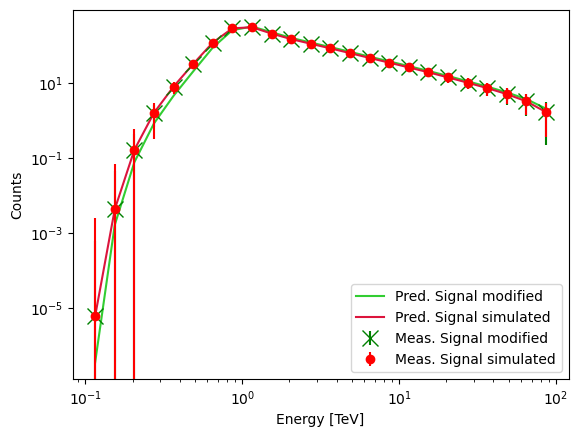

In [13]:
signal_modified = dataset_modified.npred_signal().data.sum(axis=2).sum(axis=1)
signal_simulated = dataset_simulated.npred_signal().data.sum(axis=2).sum(axis=1)

err_signal_modified = np.sqrt(signal_modified)
err_signal_simulated = np.sqrt(signal_simulated)


excess_modified = (dataset_modified.counts.data- dataset_modified.background.data)
excess_modified = excess_modified.sum(axis=2).sum(axis=1)
excess_simulated = (dataset_simulated.counts.data- dataset_simulated.background.data)
excess_simulated = excess_simulated.sum(axis=2).sum(axis=1)


plt.plot(energy_true.center, signal_modified, "-", label= "Pred. Signal modified", color = 'limegreen')
plt.plot(energy_true.center, signal_simulated, label = "Pred. Signal simulated", color = 'crimson')

plt.errorbar(energy_true.center, excess_modified, yerr = err_signal_modified, fmt =  'x',
             label = "Meas. Signal modified", color = 'green', markersize = 12)
plt.errorbar(energy_true.center, excess_simulated,yerr = err_signal_simulated, 
         fmt =  'o', label = "Meas. Signal simulated", color = 'red')


ylim = plt.ylim()
e0 = dataset_modified.models[0].parameters['reference'].value
print(e0)

#plt.vlines(e0, ylim[0], ylim[1])
plt.legend()
plt.loglog()
plt.xlabel("Energy [TeV]")
plt.ylabel("Counts")

#fig.savefig(f"plots/2-Excess_{shift}.pdf")

## dataset with nuisance parameters

In [14]:
dataset_modified_N = dataset_simulated.copy()


models = Models.read(f"{path_crab}/standard_model.yml")
from gammapy.modeling.models import PowerLawNuisanceESpectralModel

model_spectrum  = PowerLawNuisanceESpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",  
    reference_nuisance = '0 TeV')
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)


from gammapy.modeling.models import PowerLawNormNuisanceESpectralModel

bkg_spectral_model_N= PowerLawNormNuisanceESpectralModel(
    norm = '1',
    tilt = '0',
    reference_nuisance = '0TeV')

bkg_model = FoVBackgroundModel(dataset_name=dataset_modified_N.name,
                              spectral_model = bkg_spectral_model_N)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_modified_N.models = models

dataset_modified_N.edisp = edisp_modified_map



sigma_a = 0.2
sigma_n = 0.2
sigma_na = 0.01

penalising_covmatrix = [[1/sigma_a**2 + 1/sigma_na ** 2,  - 1/sigma_na**2],
                        [  - 1/sigma_na**2             ,    1/sigma_n**2 + 1/sigma_na ** 2]]

penalising_invcovmatrix =  penalising_covmatrix

dataset_modified_N.penalising_invcovmatrix = penalising_invcovmatrix


dataset_modified_N.models[0].parameters['reference_nuisance'].value = -0.02
dataset_modified_N.models[1].parameters['reference_nuisance'].value = -0.02

print(dataset_modified_N)


penality 0.020000000000000004 [-0.02 -0.02]
MapDataset
----------

  Name                            : uUd1rm2z 

  Total counts                    : 361815 
  Total background counts         : 360331.31
  Total excess counts             : 1484.08

  Predicted counts                : 361892.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1560.72

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -756739.02

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 9

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawNuisanceESpectralModel
    Spatial  model type       : GaussianSpatialModel

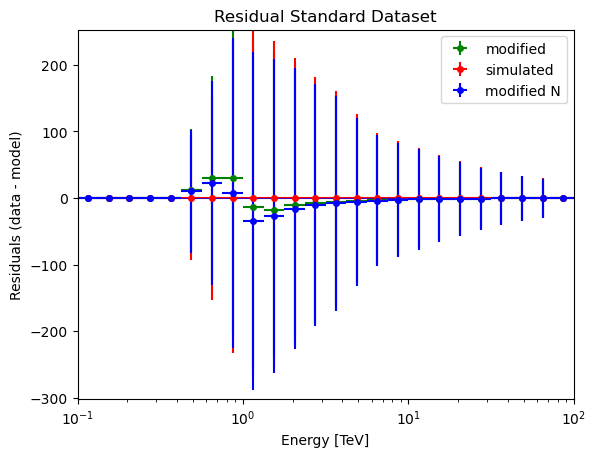

In [15]:
ax = dataset_modified.plot_residuals_spectral(color = 'green', label = "modified")
dataset_simulated.plot_residuals_spectral(ax, color = 'red', label = "simulated")
dataset_modified_N.plot_residuals_spectral(ax, color = 'blue', label = "modified N")

fig =plt.gcf()
plt.title("Residual Standard Dataset")

plt.legend()

-0.1
-0.060000000000000005
-0.020000000000000004
0.01999999999999999
0.06
0.1


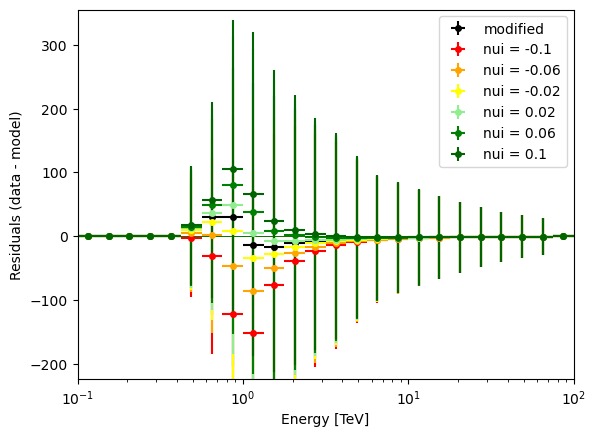

In [17]:
ref_nui_values = np.linspace(-0.1, 0.1, 6)
ax = dataset_modified.plot_residuals_spectral(color = 'black', label = "modified")

colors = ['red', 'orange', 'yellow', 'lightgreen', 'green', 'darkgreen']

for  i, r in enumerate(ref_nui_values) :
    print(r)
    dataset_modified_N.models[0].parameters['reference_nuisance'].value = r
    dataset_modified_N.models[1].parameters['reference_nuisance'].value = r
    
    dataset_modified_N.plot_residuals_spectral(ax, label = f"nui = {r:.2}",
                                              color = colors[i])
plt.legend()

In [28]:
excess = dataset_modified_N.counts.data.sum(axis=2).sum(axis=1)

In [30]:
 dataset_modified_N.npred_signal().data.sum(axis=2).sum(axis=1) - data

array([-5.90722952e-06, -3.18990792e-03, -1.08610965e-01, -9.68176273e-01,
       -4.51106798e+00, -8.62512191e+03, -2.33163752e+04, -5.41473880e+04,
       -6.40354275e+04, -5.56033724e+04, -4.43700436e+04, -3.29248545e+04,
       -2.59459561e+04, -1.59968332e+04, -9.61424250e+03, -7.41632960e+03,
       -5.63521440e+03, -4.20552301e+03, -3.07072059e+03, -2.17666325e+03,
       -1.53025611e+03, -1.13033354e+03, -8.58766430e+02,  3.79091405e-01])

-0.06
-0.027999999999999997
0.0040000000000000036
0.036000000000000004
0.068
0.1


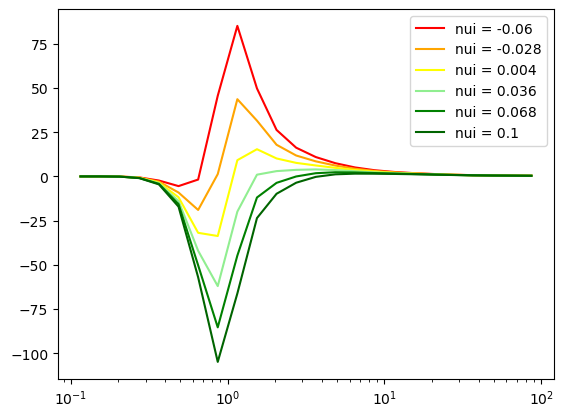

In [35]:
ref_nui_values = np.linspace(-0.06, 0.1, 6)
#ax = dataset_modified.plot_residuals_spectral(color = 'black', label = "modified")

colors = ['red', 'orange', 'yellow', 'lightgreen', 'green', 'darkgreen']

for  i, r in enumerate(ref_nui_values) :
    print(r)
    dataset_modified_N.models[0].parameters['reference_nuisance'].value = r
    dataset_modified_N.models[1].parameters['reference_nuisance'].value = r
    plt.vlines(1+r, -20,20 color )
    
    plt.plot(energy.center, dataset_modified_N.npred_signal().data.sum(axis=2).sum(axis=1) - excess_modified,
             label = f"nui = {r:.2}",
                                              color = colors[i])
plt.legend()
#plt.loglog()
plt.xscale('log')